# Redes Neuronales - TP2
## Ej 3

Implemente un perceptrón multicapa que aprenda la función lógica XOR de 2 y de 4
entradas (utilizando el algoritmo Backpropagation y actualizando en batch). Muestre
cómo evoluciona el error durante el entrenamiento.

In [130]:
import numpy as np
import matplotlib.pyplot as plt

In [131]:
class perceptron_multicapa:
    def __init__(self, capas, dim_entrada):
        self.capas = capas
        self.dim_entrada = dim_entrada
        self.lista_matrices = []
        self.lr = None
        entrada_anterior = dim_entrada
        for num_perceptrones in capas:
            matriz_pesos = np.random.uniform(-2, 2, size=(num_perceptrones, entrada_anterior + 1)) # inicialización más amplia
            self.lista_matrices.append(matriz_pesos)
            entrada_anterior = num_perceptrones

    def funcion_activacion(self, x):
        return 1 / (1 + np.exp(-x))
    
    def derivada_activacion(self, a):
        return a * (1 - a)

    def forward(self, x):
        a = x
        activaciones = [a] # todos los x de la red cuando se propaga para adelante - es el zs pasado por la función de activación
        zs = []# todos los h de la red cuando se propaga para adelante
        for W in self.lista_matrices:
            a_b = np.concatenate(([1], a))
            z = np.dot(W, a_b)
            zs.append(z)
            a = self.funcion_activacion(z)
            activaciones.append(a)
        return activaciones, zs
    
    def predecir(self, X):
        salidas = []
        for x in X:
            a = x
            for W in self.lista_matrices:
                a = np.concatenate(([1], a))
                a = self.funcion_activacion(np.dot(W, a))
            salidas.append(a.reshape(-1))  # garantiza que sea vector 1D
        return np.array(salidas).reshape(len(X), -1)

    def predecir_hard(self, X):
        salidas = self.predecir(X)
        # Si la salida es entre 0 y 1 (sigmoide), umbral en 0.5
        return (salidas >= 0.5).astype(int)

    def entrenar(self, X, Y, lr=1.0, epochs=20000):
        self.lr = lr
        n_samples = X.shape[0]
        self.error_por_epoch = []
        for epoch in range(epochs):
            grad_acum = [np.zeros_like(W) for W in self.lista_matrices]
            for i in range(n_samples):
                x = X[i]
                y = Y[i]
                activaciones, zs = self.forward(x) # tomo los h y x del paso foward
                deltas = [None] * len(self.lista_matrices) # lugar para guardar los deltas
                a_out = activaciones[-1] # la activavión de la salida es la última
                deltas[-1] = (a_out - y) * self.derivada_activacion(a_out) # el último delta es el de la salida, y se calcula como la salida deseada - la actual por la derivada de la func de act. 
                for l in range(len(self.lista_matrices)-2, -1, -1): # acá propagamos desde la salida para aras
                    W_next = self.lista_matrices[l+1][:,1:]
                    delta_next = deltas[l+1]
                    a_l = activaciones[l+1]
                    deltas[l] = np.dot(W_next.T, delta_next) * self.derivada_activacion(a_l)
                for l in range(len(self.lista_matrices)):
                    a_prev = np.concatenate(([1], activaciones[l]))
                    grad_acum[l] += np.outer(deltas[l], a_prev)
            for l in range(len(self.lista_matrices)):
                self.lista_matrices[l] -= self.lr * grad_acum[l] / n_samples
            if epoch % 100 == 0 or epoch == epochs-1:
                pred = self.predecir(X)
                loss = np.mean((pred - Y) ** 2) # acá se va guardando el ECM para luego visualizarlo, pero se hace cada tanto, no los miles de puntos. 
                self.error_por_epoch.append(loss)

In [132]:
# datos para la XOR de 2 entradas y 1 salida (corregido)
A = np.array([0, 0, 1, 1])
B = np.array([0, 1, 0, 1])
Y12 = np.array([0, 1, 1, 0])
datos_XOR2 = np.column_stack((A, B, Y12))


In [133]:
# los construí en 1 y -1 pero desp lo paso a 0 y 1, no lo hago acá porque cada vez que hago un control replace cambio todos los -1 del resto del código

A = np.array([-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1])
B = np.array([-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1])
C = np.array([-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,1,1,1,1])
D = np.array([-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1])
Y14 = np.array([-1,1,1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1])
datos_XOR4 = np.column_stack((A, B, C, D, Y14))


In [134]:
# ahora toca entrenar el perceptron con estos datos
test2 = perceptron_multicapa(capas=[4,1], dim_entrada=2) # para la XOR de 2 entradas y 1 salida
test4 = perceptron_multicapa(capas=[4, 1], dim_entrada=4) # para la XOR de 4 entradas y 1 salida

# entrenamos ambos modelos con sus respectivos datos y targets 
X2 = datos_XOR2[:, 0:2]
Y2 = datos_XOR2[:, 2].reshape(-1, 1)  # targets 0/1 para sigmoide


test2.entrenar(X2, Y2, lr=0.1, epochs=20000)


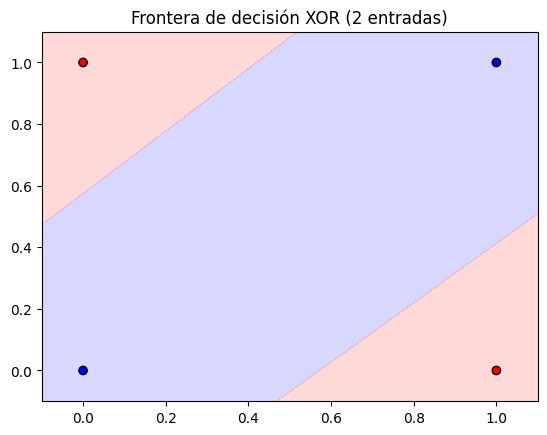

In [135]:
# Graficar frontera de decisión para XOR de 2 entradas
h = 0.01
x_min, x_max = X2[:,0].min() - 0.1, X2[:,0].max() + 0.1
y_min, y_max = X2[:,1].min() - 0.1, X2[:,1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = test2.predecir(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[0,0.5,1], alpha=0.3, cmap="bwr")
plt.scatter(X2[:,0], X2[:,1], c=Y2[:,0], cmap="bwr", edgecolors="k")
plt.title("Frontera de decisión XOR (2 entradas)")
plt.show()


In [136]:
# Mostrar predicciones hard y soft para los 4 puntos de la XOR de 2 entradas
print("Entradas\tTarget\tSalida sigmoide\tPredicción (umbral 0.5)")
preds = test2.predecir(X2)
for x, y, p in zip(X2, Y2, preds):
    print(f"{x}\t{int(y[0])}\t{p[0]:.3f}\t\t{int(p[0]>=0.5)}")

Entradas	Target	Salida sigmoide	Predicción (umbral 0.5)
[0 0]	0	0.065		0
[0 1]	1	0.939		1
[1 0]	1	0.945		1
[1 1]	0	0.054		0


In [137]:
X4 = datos_XOR4[:, 0:4]
Y4 = ((datos_XOR4[:, 4] + 1) / 2).reshape(-1, 1)  # targets 0/1 para sigmoid

test4.entrenar(X4, Y4, lr=0.1, epochs=20000)

In [138]:
# Mostrar predicciones hard y soft para los 4 puntos de la XOR de 4 entradas
print("Entradas\tTarget\tSalida sigmoide\tPredicción (umbral 0.5)")
preds = test4.predecir(X4)
for x, y, p in zip(X4, Y4, preds):
    print(f"{x}\t{int(y[0])}\t{p[0]:.3f}\t\t{int(p[0]>=0.5)}")

Entradas	Target	Salida sigmoide	Predicción (umbral 0.5)
[-1 -1 -1 -1]	0	0.396		0
[ 1 -1 -1 -1]	1	0.806		1
[-1  1 -1 -1]	1	0.839		1
[ 1  1 -1 -1]	0	0.074		0
[-1 -1  1 -1]	1	0.796		1
[ 1 -1  1 -1]	0	0.106		0
[-1  1  1 -1]	0	0.053		0
[ 1  1  1 -1]	0	0.055		0
[-1 -1 -1  1]	1	0.815		1
[ 1 -1 -1  1]	0	0.035		0
[-1  1 -1  1]	0	0.069		0
[ 1  1 -1  1]	0	0.070		0
[-1 -1  1  1]	0	0.021		0
[ 1 -1  1  1]	0	0.016		0
[-1  1  1  1]	0	0.054		0
[1 1 1 1]	0	0.048		0


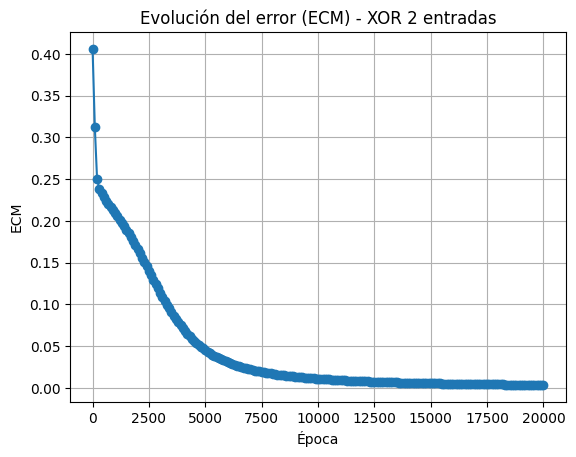

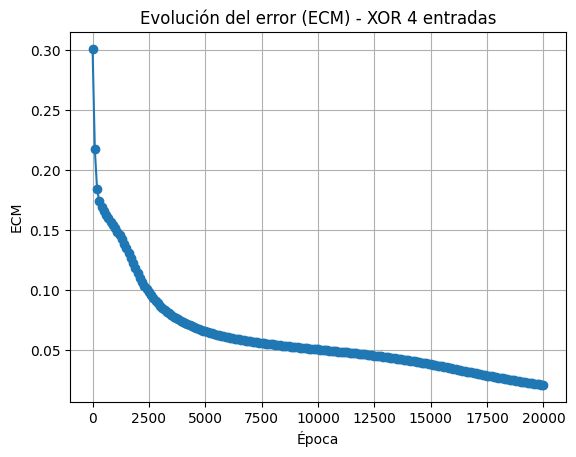

In [139]:
def graficar_error(modelo, titulo):
    plt.figure()
    plt.plot(np.arange(len(modelo.error_por_epoch)) * 100, modelo.error_por_epoch, marker='o')
    plt.xlabel('Época')
    plt.ylabel('ECM')
    plt.title(titulo)
    plt.grid(True)
    plt.show()

# Graficar error para XOR 2 entradas
graficar_error(test2, "Evolución del error (ECM) - XOR 2 entradas")

# Graficar error para XOR 4 entradas
graficar_error(test4, "Evolución del error (ECM) - XOR 4 entradas")

la xor de 4 cae más rápido xq tiene 16 muestras para 4 dimensiones, mucbo menos proporiconalmente que 4 muestras para 2. diría que está más vacio el espacio R4 que el R2. 

mencionar lo de función activación según 0/1 o -1/1 en muestras